In [1]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import random
import sys
import os

import sys
import os

# Get the absolute path of the src folder
sys.path.append(os.path.abspath("src"))


from utils import show_image, preprocess_image, clip_eps, get_label
from watermark import generate_adversaries_targeted, perturb_image, verify_watermark

2025-02-11 15:58:16.356273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-11 15:58:16.356296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-11 15:58:16.357550: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 15:58:16.365484: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
EPS = 5./255
IMAGENET_LABELS = "./data/imagenet_class_index.json"

with open(IMAGENET_LABELS) as f:
    IMAGENET_CLASSES = {int(i):x[1] for i,x in json.load(f).items()}

In [3]:
k = 4
secret_labels = random.sample(range(1000), k)
print("Secret labels:", secret_labels)
print("Secret label names:", [IMAGENET_CLASSES[label] for label in secret_labels])

Secret labels: [17, 646, 683, 719]
Secret label names: ['jay', 'maze', 'oboe', 'piggy_bank']


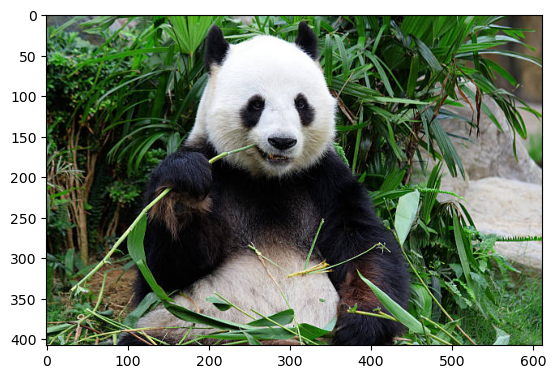

2025-02-11 15:58:19.366021: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10534 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:86:00.0, compute capability: 6.1


In [4]:
sample_image = show_image("./data/imagenet/giant_panda/giantpanda.jpg")
preprocessed_image = preprocess_image(sample_image, preprocess=True)
resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=True, classifier_activation=None)

In [5]:
preds = resnet50.predict(preprocessed_image)
print("Logits:", decode_predictions(preds, top=3)[0])
print("Class idx:", preds.argmax())

2025-02-11 15:58:22.371822: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


1/1 [==============================] - 2s 2s/step
Logits: [('n02510455', 'giant_panda', 17.563171), ('n02509815', 'lesser_panda', 10.099155), ('n02488702', 'colobus', 9.428918)]
Class idx: 388


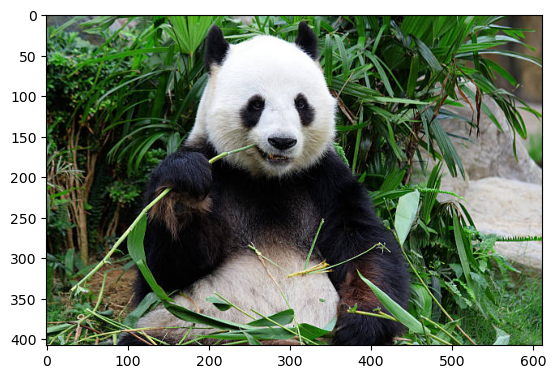

1/1 [==============================] - 0s 32ms/step
Logits before adv.: [('n02510455', 'giant_panda', 17.555876), ('n02509815', 'lesser_panda', 10.108606), ('n02488702', 'colobus', 9.493948)]

Predictions for secret labels BEFORE perturbation:
Label: jay (Index: 17), Logit: 1.8479315042495728
Label: maze (Index: 646), Logit: 0.15902402997016907
Label: oboe (Index: 683), Logit: -0.3909199833869934
Label: piggy_bank (Index: 719), Logit: -1.4877309799194336
Iteration 0, Loss: 70.10181427001953


2025-02-11 15:58:24.547769: I external/local_xla/xla/service/service.cc:168] XLA service 0x5630ce3df3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-11 15:58:24.547820: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-02-11 15:58:24.554176: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739318304.718853     731 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Iteration 20, Loss: 41.00439453125
Iteration 40, Loss: 33.57585525512695
Iteration 60, Loss: 32.84696960449219
Iteration 80, Loss: 32.50224304199219
Iteration 100, Loss: 32.170379638671875
Iteration 120, Loss: 31.81575584411621
Iteration 140, Loss: 31.391931533813477
Iteration 160, Loss: 30.95309066772461
Iteration 180, Loss: 30.49929428100586
Iteration 200, Loss: 30.04330825805664
Iteration 220, Loss: 29.625944137573242
Iteration 240, Loss: 29.212860107421875
Iteration 260, Loss: 28.742372512817383
Iteration 280, Loss: 28.243938446044922
Iteration 300, Loss: 27.73101043701172
Iteration 320, Loss: 27.22085189819336
Iteration 340, Loss: 26.737913131713867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


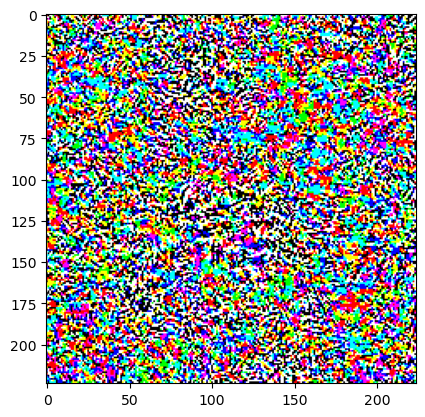

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


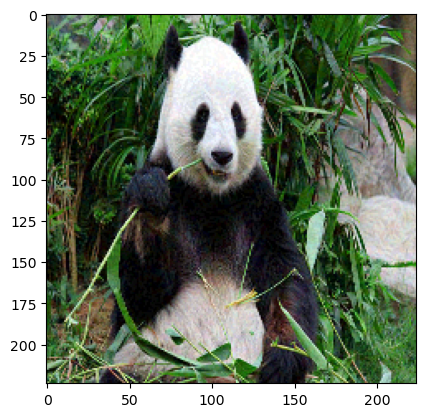

1/1 [==============================] - 0s 35ms/step
Logits after adv.: [('n02510455', 'giant_panda', 5.6248937), ('n01806143', 'peacock', 4.0190377), ('n02843684', 'birdhouse', 3.8990576)]

Predictions for secret labels:
Label: jay (Index: 17), Logit: 2.772794485092163
Label: maze (Index: 646), Logit: 1.7136693000793457
Label: oboe (Index: 683), Logit: 1.2644902467727661
Label: piggy_bank (Index: 719), Logit: 1.1849206686019897
 Label: 17 , logit_diff : 0.9248629808425903
Watermark NOT verified.


In [6]:
#@title Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
perturb_image("./examples/panda.jpg", 388, secret_labels, resnet50, optimizer,EPS)